# Project Objectives:
1. **Analyse Usage and Demand Patterns:** Examine the extensive trip data available in Co-Wheels’ booking system (TripIQ) to identify patterns in vehicle usage and demand across different locations and times.
2. **Design and Develop a Pricing Model and Tool:**
     1. Create a pricing model that incorporates fixed and variable costs, including fuel and electricity, to determine optimal hourly and daily rates for different locations and times.
     2. Develop a straightforward tool that allows Co-Wheels to input various cost factors and receive tailored pricing options based on location, demand, and seasonal variations.   
4. **Evaluate Seasonal and Temporal Variations:** Assess the impact of seasonal changes and time-of-day variations on car-sharing demand and integrate these factors into the pricing model.
5. **Assess Profitability and Utilisation Impact:** Model potential outcomes of different pricing strategies to evaluate their impact on profitability and vehicle utilisation rates in various locations.
6. **Validate pricing tool:** Test the pricing tool with real-world data to ensure its accuracy and effectiveness in optimising Co-Wheels’ pricing strategy.

# 1. Loading libraries and data

In [ ]:
pip install category_encoders

In [ ]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
from scipy import stats
from matplotlib.ticker import FuncFormatter
from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import joblib

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Data location
DATA_PATH = "/content/drive/MyDrive/MSc Dissertation/data/"
# Encoders location
ENCODERS_PATH = "/content/drive/MyDrive/MSc Dissertation/encoders/"
# Model location
MODEL_PATH = "/content/drive/MyDrive/MSc Dissertation/models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Load data

In [ ]:
df_transformed = pd.read_csv(DATA_PATH + 'transformed_dataset.csv')
df = pd.read_csv(DATA_PATH + 'scaled_dataset.csv')

print('Scaled data: ', df.shape)
print('Transformed data: ', df_transformed.shape)

Scaled data:  (378614, 57)
Transformed data:  (378614, 39)


In [ ]:
df.head()

,vehicle_description,vehicle_registration,location_0,location_1,location_2,location_3,location_4,location_5,location_6,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year,season_Winter,season_Autumn,season_Summer,season_Spring,is_holiday_1.0,is_holiday_0.0,Vehicle Type_City,Vehicle Type_Everyday,Vehicle Type_Family,Vehicle Type_Van,Vehicle Type_7 Seater,Fuel Type_Petrol,Fuel Type_EV,Fuel Type_Hydrogen,is_peak_hour_1.0,is_peak_hour_0.0,is_weekend_1.0,is_weekend_0.0,hourly_rate,daily_rate,per_mile
0,White Toyota Aygo XPlay Nav (NL66 NKZ),NL66 NKZ,0,0,0,0,0,0,1,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,4.934474,2020-01-01 23:00:00,23,2,1,2020,2020-01-02 08:00:00,8,3,1,2020,6.293419,4.418841,0.0,0.0,1.0,2.757475,2.351375,3.229222,2020-01-01 22:56:00,22,2,1,2020,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,4.75,33.25,0.18
1,Renault Zoe EV (DL68 LNK),DL68 LNK,0,0,0,0,0,0,1,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,5.278115,2020-01-01 22:45:00,22,2,1,2020,2020-01-02 02:30:00,2,3,1,2020,5.420535,1.791759,0.0,0.0,1.0,0.000000,2.484907,2.484907,2020-01-01 22:36:00,22,2,1,2020,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,5.50,38.50,0.18
2,White Toyota Yaris Petrol Hybrid (Automatic) ...,ND19 HWY,0,0,0,0,0,1,0,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,4.787492,2020-01-01 21:30:00,21,2,1,2020,2020-01-01 23:30:00,23,2,1,2020,4.795791,1.945910,2.0,0.0,0.0,0.732368,2.484907,2.571084,2020-01-01 20:50:00,20,2,1,2020,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,5.50,38.50,0.18
3,White Toyota Aygo XPlay (NL68 JVP),NL68 JVP,0,0,0,0,0,1,1,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,2.833213,2020-01-01 21:15:00,21,2,1,2020,2020-01-01 21:45:00,21,2,1,2020,3.433987,1.945910,0.5,0.0,0.0,0.732368,1.217876,1.495149,2020-01-01 05:15:00,5,2,1,2020,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,4.75,33.25,0.18
4,White Toyota Yaris Hybrid NJ68 JHV Automatic 5...,NJ68 JHV,0,0,0,0,1,0,0,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,6.598509,2020-01-01 20:30:00,20,2,1,2020,2020-01-02 20:30:00,20,3,1,2020,6.820016,3.988984,0.0,1.0,0.0,2.355178,3.676301,3.892636,2019-12-26 08:35:00,8,3,12,2019,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,5.50,38.50,0.18


In [ ]:
df_transformed.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year,season,is_holiday,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,is_weekend,is_peak_hour
0,White Toyota Aygo XPlay Nav (NL66 NKZ),NL66 NKZ,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,4.934474,2020-01-01 23:00:00,23,2,1,2020,2020-01-02 08:00:00,8,3,1,2020,6.293419,4.418841,0.0,0.0,1.0,2.757475,2.351375,3.229222,2020-01-01 22:56:00,22,2,1,2020,Winter,1,City,Petrol,4.75,33.25,0.18,0,0
1,Renault Zoe EV (DL68 LNK),DL68 LNK,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,5.278115,2020-01-01 22:45:00,22,2,1,2020,2020-01-02 02:30:00,2,3,1,2020,5.420535,1.791759,0.0,0.0,1.0,0.000000,2.484907,2.484907,2020-01-01 22:36:00,22,2,1,2020,Winter,1,Everyday,EV,5.50,38.50,0.18,0,0
2,White Toyota Yaris Petrol Hybrid (Automatic) ...,ND19 HWY,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,4.787492,2020-01-01 21:30:00,21,2,1,2020,2020-01-01 23:30:00,23,2,1,2020,4.795791,1.945910,2.0,0.0,0.0,0.732368,2.484907,2.571084,2020-01-01 20:50:00,20,2,1,2020,Winter,1,Everyday,Petrol,5.50,38.50,0.18,0,0
3,White Toyota Aygo XPlay (NL68 JVP),NL68 JVP,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,2.833213,2020-01-01 21:15:00,21,2,1,2020,2020-01-01 21:45:00,21,2,1,2020,3.433987,1.945910,0.5,0.0,0.0,0.732368,1.217876,1.495149,2020-01-01 05:15:00,5,2,1,2020,Winter,1,City,Petrol,4.75,33.25,0.18,0,0
4,White Toyota Yaris Hybrid NJ68 JHV Automatic 5...,NJ68 JHV,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,6.598509,2020-01-01 20:30:00,20,2,1,2020,2020-01-02 20:30:00,20,3,1,2020,6.820016,3.988984,0.0,1.0,0.0,2.355178,3.676301,3.892636,2019-12-26 08:35:00,8,3,12,2019,Winter,1,Everyday,Petrol,5.50,38.50,0.18,0,0


In [ ]:
# Convert to pandas datetime object
df['booking_billed_start'] = pd.to_datetime(df['booking_billed_start'])
df_transformed['booking_billed_start'] = pd.to_datetime(df_transformed['booking_billed_start'])

# Sort data by booking_actual_start to ensure temporal order
df = df.sort_values(by='booking_billed_start').reset_index(drop=True)
df_transformed = df_transformed.sort_values(by='booking_billed_start').reset_index(drop=True)

# Drop unnecessary columns
df.drop(columns=['vehicle_description', 'vehicle_registration', 'booking_actual_start',
                 'booking_actual_end', 'booking_billed_end', 'booking_created_at'], inplace=True)

df.shape

(378614, 51)

In [ ]:
df.head()

,location_0,location_1,location_2,location_3,location_4,location_5,location_6,booking_id,booking_actual_duration,booking_billed_start,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year,season_Winter,season_Autumn,season_Summer,season_Spring,is_holiday_1.0,is_holiday_0.0,Vehicle Type_City,Vehicle Type_Everyday,Vehicle Type_Family,Vehicle Type_Van,Vehicle Type_7 Seater,Fuel Type_Petrol,Fuel Type_EV,Fuel Type_Hydrogen,is_peak_hour_1.0,is_peak_hour_0.0,is_weekend_1.0,is_weekend_0.0,hourly_rate,daily_rate,per_mile
0,0,0,0,0,1,1,0,63a1866c-0ca2-11e9-b63c-bbf97d8700d8,4.454347,2018-12-31 02:30:00,2,0,12,2018,4,0,12,2018,4.663439,3.367296,1.75,0.0,0.0,1.798404,2.363680,2.751748,2,0,12,2018,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,5.50,38.50,0.18
1,0,0,0,0,1,1,0,5da81746-0c78-11e9-8e9e-017b0b6178d0,3.178054,2018-12-31 08:00:00,8,0,12,2018,8,0,12,2018,3.828641,1.609438,0.75,0.0,0.0,0.542324,1.635106,1.766442,21,6,12,2018,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,5.50,38.50,0.18
2,0,0,0,0,0,0,1,ee131264-0c63-11e9-8d53-a129eaa6e810,4.927254,2018-12-31 08:15:00,8,0,12,2018,11,0,12,2018,5.111988,2.772589,2.75,0.0,0.0,1.308333,2.780681,2.935451,18,6,12,2018,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,5.50,38.50,0.18
3,0,0,0,1,0,1,1,4ced6a56-0c4f-11e9-814f-63c5d39c3910,4.672829,2018-12-31 08:30:00,8,0,12,2018,10,0,12,2018,4.795791,2.397895,2.00,0.0,0.0,0.000000,2.484907,2.484907,16,6,12,2018,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,5.50,38.50,0.18
4,0,0,0,0,1,1,1,2b4e190c-0bb6-11e9-8b21-79c4cede1e0f,4.553877,2018-12-31 08:30:00,8,0,12,2018,11,0,12,2018,5.017280,2.397895,2.50,0.0,0.0,1.029619,2.555676,2.686486,22,5,12,2018,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,4.75,33.25,0.18


In [ ]:
df_transformed.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year,season,is_holiday,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,is_weekend,is_peak_hour
0,White Toyota Yaris Hybrid NJ68 VPA Automatic 5...,NJ68 VPA,Glasgow,63a1866c-0ca2-11e9-b63c-bbf97d8700d8,2018-12-31 02:25:00,2018-12-31 03:50:00,4.454347,2018-12-31 02:30:00,2,0,12,2018,2018-12-31 04:15:00,4,0,12,2018,4.663439,3.367296,1.75,0.0,0.0,1.798404,2.363680,2.751748,2018-12-31 02:18:00,2,0,12,2018,Autumn,1,Everyday,Petrol,5.50,38.50,0.18,0,0
1,Toyota Yaris Hybrid NG18 BMY Automatic 5 Seats,NG18 BMY,Glasgow,5da81746-0c78-11e9-8e9e-017b0b6178d0,2018-12-31 08:11:00,2018-12-31 08:34:00,3.178054,2018-12-31 08:00:00,8,0,12,2018,2018-12-31 08:45:00,8,0,12,2018,3.828641,1.609438,0.75,0.0,0.0,0.542324,1.635106,1.766442,2018-12-30 21:17:00,21,6,12,2018,Autumn,1,Everyday,Petrol,5.50,38.50,0.18,0,0
2,Toyota Yaris Manual (NK17 RYM),NK17 RYM,Bristol,ee131264-0c63-11e9-8d53-a129eaa6e810,2018-12-31 08:18:00,2018-12-31 10:35:00,4.927254,2018-12-31 08:15:00,8,0,12,2018,2018-12-31 11:00:00,11,0,12,2018,5.111988,2.772589,2.75,0.0,0.0,1.308333,2.780681,2.935451,2018-12-30 18:51:00,18,6,12,2018,Autumn,1,Everyday,Petrol,5.50,38.50,0.18,0,0
3,Renault Zoe EV (SD67 GFV),SD67 GFV,Aberdeen,4ced6a56-0c4f-11e9-814f-63c5d39c3910,2018-12-31 08:25:00,2018-12-31 10:11:00,4.672829,2018-12-31 08:30:00,8,0,12,2018,2018-12-31 10:30:00,10,0,12,2018,4.795791,2.397895,2.00,0.0,0.0,0.000000,2.484907,2.484907,2018-12-30 16:23:00,16,6,12,2018,Autumn,1,Everyday,EV,5.50,38.50,0.18,0,0
4,Toyota Aygo XPlay Nav (NL66 UBU),NL66 UBU,Oxford,2b4e190c-0bb6-11e9-8b21-79c4cede1e0f,2018-12-31 09:10:00,2018-12-31 10:44:00,4.553877,2018-12-31 08:30:00,8,0,12,2018,2018-12-31 11:00:00,11,0,12,2018,5.017280,2.397895,2.50,0.0,0.0,1.029619,2.555676,2.686486,2018-12-29 22:07:00,22,5,12,2018,Autumn,1,City,Petrol,4.75,33.25,0.18,0,0


## 1.2 Load Encoders

In [ ]:
# Load the encoders
binary_encoder = joblib.load(ENCODERS_PATH + 'binary_encoder.pkl')
one_hot_encoder = joblib.load(ENCODERS_PATH + 'one_hot_encoder.pkl')

# 2. Final Model Building Code

In [ ]:
# Define function to create and compile neural network model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Function to train and evaluate models
def train_evaluate_models(df):
    vehicle_types = [col for col in df.columns if col.startswith('Vehicle Type_')]
    results = {}
    predictions_df = pd.DataFrame()

    for vehicle_type in vehicle_types:
        vehicle_data = df[df[vehicle_type] == 1].copy()

        # Sort the data based on time
        vehicle_data = vehicle_data.sort_values(by='booking_billed_start')

        # Define features and target for the current vehicle type
        features_vehicle = vehicle_data.drop(columns=['hourly_rate', 'daily_rate', 'booking_billed_start', 'booking_id'])
        target_hourly_vehicle = vehicle_data['hourly_rate']
        target_daily_vehicle = vehicle_data['daily_rate']

        # Split the data based on time
        split_ratio = 0.8
        split_index_vehicle = int(len(vehicle_data) * split_ratio)

        X_train = features_vehicle.iloc[:split_index_vehicle]
        X_test = features_vehicle.iloc[split_index_vehicle:]
        X_test_copy = vehicle_data.drop(columns=['hourly_rate', 'daily_rate']).iloc[split_index_vehicle:]
        y_train_hourly = target_hourly_vehicle.iloc[:split_index_vehicle]
        y_test_hourly = target_hourly_vehicle.iloc[split_index_vehicle:]
        y_train_daily = target_daily_vehicle.iloc[:split_index_vehicle]
        y_test_daily = target_daily_vehicle.iloc[split_index_vehicle:]

        # Set values to None
        hourly_mae = None
        hourly_rmse = None
        daily_mae = None
        daily_rmse = None
        y_pred_hourly = None
        y_pred_daily = None


        if 'City' in vehicle_type or '7 Seater' in vehicle_type:
            # Normalize the features
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Save the scaler
            joblib.dump(scaler, ENCODERS_PATH + f'scaler_{vehicle_type}.pkl')

            # Neural Network for both hourly and daily rates
            model_hourly = create_nn_model(X_train.shape[1])
            model_hourly.fit(X_train, y_train_hourly, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            model_hourly.save(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_nn_hourly_rate_model.keras')

            # Evaluate the hourly rate model
            y_pred_hourly = model_hourly.predict(X_test)
            hourly_mae = np.round(mean_absolute_error(y_test_hourly, y_pred_hourly), 5)
            hourly_rmse = np.round(np.sqrt(mean_squared_error(y_test_hourly, y_pred_hourly)), 5)

            model_daily = create_nn_model(X_train.shape[1])
            model_daily.fit(X_train, y_train_daily, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            model_daily.save(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_nn_daily_rate_model.keras')

            # Evaluate the daily rate model
            y_pred_daily = model_daily.predict(X_test)
            daily_mae = np.round(mean_absolute_error(y_test_daily, y_pred_daily), 5)
            daily_rmse = np.round(np.sqrt(mean_squared_error(y_test_daily, y_pred_daily)), 5)

            print(f"Vehicle Type: {vehicle_type.replace('Vehicle Type_', '')}")
            print("Hourly Rate Model - MAE:", hourly_mae)
            print("Hourly Rate Model - RMSE:", hourly_rmse)
            print("Daily Rate Model - MAE:", daily_mae)
            print("Daily Rate Model - RMSE:", daily_rmse)
            print("\n")

        elif 'Everyday' in vehicle_type or 'Van' in vehicle_type:
            # XGBRegressor for both hourly and daily rates
            model_hourly = XGBRegressor()
            model_hourly.fit(X_train, y_train_hourly)
            joblib.dump(model_hourly, MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_hourly_rate_model.pkl')

            model_daily = XGBRegressor()
            model_daily.fit(X_train, y_train_daily)
            joblib.dump(model_daily, MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_daily_rate_model.pkl')

            # Evaluate models
            y_pred_hourly = model_hourly.predict(X_test)
            y_pred_daily = model_daily.predict(X_test)

            # hourly and daily mae and rmse
            hourly_mae = np.round(mean_absolute_error(y_test_hourly, y_pred_hourly), 5)
            hourly_rmse = np.round(np.sqrt(mean_squared_error(y_test_hourly, y_pred_hourly)), 5)
            daily_mae = np.round(mean_absolute_error(y_test_daily, y_pred_daily), 5)
            daily_rmse = np.round(np.sqrt(mean_squared_error(y_test_daily, y_pred_daily)), 5)

            print(f"Vehicle Type: {vehicle_type.replace('Vehicle Type_', '')}")
            print("Hourly Rate Model - MAE:", hourly_mae)
            print("Hourly Rate Model - RMSE:", hourly_rmse)
            print("Daily Rate Model - MAE:", daily_mae)
            print("Daily Rate Model - RMSE:", daily_rmse)
            print("\n")

        elif 'Family' in vehicle_type:
            # XGBRegressor for hourly rate, DecisionTreeRegressor for daily rate
            model_hourly = XGBRegressor()
            model_hourly.fit(X_train, y_train_hourly)
            joblib.dump(model_hourly, MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_hourly_rate_model.pkl')

            model_daily = DecisionTreeRegressor()
            model_daily.fit(X_train, y_train_daily)
            joblib.dump(model_daily, MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_dt_daily_rate_model.pkl')

            # Evaluate models
            y_pred_hourly = model_hourly.predict(X_test)
            y_pred_daily = model_daily.predict(X_test)

            # hourly and daily mae and rmse
            hourly_mae = np.round(mean_absolute_error(y_test_hourly, y_pred_hourly), 5)
            hourly_rmse = np.round(np.sqrt(mean_squared_error(y_test_hourly, y_pred_hourly)), 5)
            daily_mae = np.round(mean_absolute_error(y_test_daily, y_pred_daily), 5)
            daily_rmse = np.round(np.sqrt(mean_squared_error(y_test_daily, y_pred_daily)), 5)

            print(f"Vehicle Type: {vehicle_type.replace('Vehicle Type_', '')}")
            print("Hourly Rate Model - MAE:", hourly_mae)
            print("Hourly Rate Model - RMSE:", hourly_rmse)
            print("Daily Rate Model - MAE:", daily_mae)
            print("Daily Rate Model - RMSE:", daily_rmse)
            print("\n")

        # Inverse transform the location columns
        location_columns = [col for col in X_test_copy.columns if col.startswith('location_')]
        X_test_copy['location'] = binary_encoder.inverse_transform(X_test_copy[location_columns])['location']

        # Add predictions to the dataframe
        temp_df = pd.DataFrame({
            'vehicle_type': vehicle_type.replace('Vehicle Type_', ''),
            'location': X_test_copy['location'],
            'booking_billed_start': X_test_copy['booking_billed_start'],
            'booking_created_at_hour': X_test_copy['booking_created_at_hour'],
            'booking_id': X_test_copy['booking_id'],
            'booking_mileage': X_test_copy['booking_mileage'],
            'booking_rates_hours': X_test_copy['booking_rates_hours'],
            'booking_rates_24hours': X_test_copy['booking_rates_24hours'],
            'per_mile': X_test_copy['per_mile'],
            'booking_actual_cost_distance': X_test_copy['booking_actual_cost_distance'],
            'booking_actual_cost_time': X_test_copy['booking_actual_cost_time'],
            'booking_actual_cost_total': X_test_copy['booking_actual_cost_total'],
            'actual_hourly': y_test_hourly.tolist(),
            'predicted_hourly': y_pred_hourly.flatten().tolist(),
            'actual_daily': y_test_daily.tolist(),
            'predicted_daily': y_pred_daily.flatten().tolist()
        })

        predictions_df = pd.concat([predictions_df, temp_df], axis=0, ignore_index=True)

        # hourly and daily mae and rmse
        results[vehicle_type.replace('Vehicle Type_', '')] = {
            'hourly_rate': {
                'MAE': hourly_mae,
                'RMSE': hourly_rmse
            },
            'daily_rate': {
                'MAE': daily_mae,
                'RMSE': daily_rmse
            }
        }

    return results, predictions_df

In [ ]:
results, predictions_df = train_evaluate_models(df)

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Vehicle Type: City
Hourly Rate Model - MAE: 0.35595
Hourly Rate Model - RMSE: 0.51241
Daily Rate Model - MAE: 6.0828
Daily Rate Model - RMSE: 7.44567


Vehicle Type: Everyday
Hourly Rate Model - MAE: 0.64146
Hourly Rate Model - RMSE: 0.83981
Daily Rate Model - MAE: 2.92157
Daily Rate Model - RMSE: 3.53526


Vehicle Type: Family
Hourly Rate Model - MAE: 0.42262
Hourly Rate Model - RMSE: 0.55651
Daily Rate Model - MAE: 0.00046
Daily Rate Model - RMSE: 0.02727


Vehicle Type: Van
Hourly Rate Model - MAE: 0.76837
Hourly Rate Model - RMSE: 1.19642
Daily Rate Model - MAE: 3.10934
Daily Rate Model - RMSE: 4.3839


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Vehicle Type: 7 Seater
Hourly Rate Model - MAE: 0.10785
Hourly Rate Model - RMSE: 0.13241
Daily Rate Model - MAE: 1.51817
Daily Rate Model - RMSE: 1.9276




In [ ]:
print(results)

{'City': {'hourly_rate': {'MAE': 0.35595, 'RMSE': 0.51241}, 'daily_rate': {'MAE': 6.0828, 'RMSE': 7.44567}}, 'Everyday': {'hourly_rate': {'MAE': 0.64146, 'RMSE': 0.83981}, 'daily_rate': {'MAE': 2.92157, 'RMSE': 3.53526}}, 'Family': {'hourly_rate': {'MAE': 0.42262, 'RMSE': 0.55651}, 'daily_rate': {'MAE': 0.00046, 'RMSE': 0.02727}}, 'Van': {'hourly_rate': {'MAE': 0.76837, 'RMSE': 1.19642}, 'daily_rate': {'MAE': 3.10934, 'RMSE': 4.3839}}, '7 Seater': {'hourly_rate': {'MAE': 0.10785, 'RMSE': 0.13241}, 'daily_rate': {'MAE': 1.51817, 'RMSE': 1.9276}}}


In [ ]:
predictions_df.head()

,vehicle_type,location,booking_billed_start,booking_created_at_hour,booking_id,booking_mileage,booking_rates_hours,booking_rates_24hours,per_mile,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,actual_hourly,predicted_hourly,actual_daily,predicted_daily
0,City,Oxford,2021-09-25 15:15:00,13,4430431c-1dfd-11ec-bc0f-7b28061821e2,2.995732,3.75,0.0,0.18,1.486140,2.934389,3.101443,4.75,4.750588,33.25,32.863228
1,City,Bristol,2021-09-25 15:15:00,9,83bd6392-1ddb-11ec-8c34-1bce318b402c,3.367296,0.00,1.0,0.18,1.798404,3.533687,3.670970,4.75,4.750588,33.25,32.862843
2,City,Aberdeen,2021-09-25 15:30:00,9,d20b602e-1dd8-11ec-b8bc-c15d9e6a6088,2.079442,1.50,0.0,0.18,0.815365,2.095561,2.239645,4.75,4.750588,33.25,32.862991
3,City,Aberdeen,2021-09-25 15:45:00,15,2343f92c-1e0d-11ec-9b69-e96877a3f019,2.079442,1.50,0.0,0.18,0.815365,2.095561,2.239645,4.75,4.750588,33.25,32.862984
4,City,Gateshead,2021-09-25 16:45:00,16,2ae7494c-1e15-11ec-91e6-cb2332bcc51e,2.302585,2.00,0.0,0.18,0.963174,2.351375,2.494857,4.75,4.750588,33.25,32.863308


# 3. Demand Factor

In [ ]:
# define a function for popular location based demand factor
def popular_location_demand_factor(historical_data, location):
    # Calculate the number of bookings for each location
    demand_location = historical_data.groupby('location').size()
    demand_location = pd.DataFrame(demand_location, columns=['bookings'])

    if location not in demand_location.index:
        return 0

    # Identify demanded locations
    threshold = np.int32(np.round(np.percentile(demand_location['bookings'], 75)))  # Example threshold for peak hours
    demand_locations = demand_location[demand_location['bookings'] >= threshold].index.tolist()
    max_count = demand_location['bookings'].max()
    location_demand = np.round((demand_location['bookings'] / max_count).mean(), 2)

    # If location is in demand_locations then location has higher demand than other locations.
    if location in demand_locations:
        return location_demand
    else:
        return 0

In [ ]:
# define a function for peak hour demand factor
def peak_hour_demand_factor(historical_data, location, hour):
    # select subset of data based on location
    location_data = historical_data[historical_data['location'] == location]

    if location_data.empty:
        return 0

    # seperate hourly bookings with location
    # Aggregate bookings by hour
    hourly_bookings = location_data.groupby('booking_created_at_hour').size()
    hourly_bookings = pd.DataFrame(hourly_bookings, columns=['bookings'])

    # Identify peak hours
    threshold = np.int32(np.round(np.percentile(hourly_bookings['bookings'], 75)))  # Example threshold for peak hours
    peak_hours = hourly_bookings[hourly_bookings['bookings'] >= threshold].index.tolist()
    max_count = hourly_bookings['bookings'].max()
    peak_hour_demand = np.round((hourly_bookings['bookings'] / max_count).mean(), 2)

    # If hour is in peak_hours then it has higher demand than other hours.
    if hour in peak_hours:
        return peak_hour_demand
    else:
        return 0

In [ ]:
# define a function for demand factor
def demand_factor(historical_data, location, hour):
    hour_demand_factor = peak_hour_demand_factor(historical_data, location, hour)
    location_demand_factor = popular_location_demand_factor(historical_data, location)
    final_demand_factor = np.round(np.mean([hour_demand_factor, location_demand_factor]), 5)
    return final_demand_factor

In [ ]:
# Sort dataset based on booking_billed_start
predictions_df.sort_values(by='booking_billed_start', inplace=True)

In [ ]:
# Apply demand factor to predicted dataframe
predictions_df['demand_factor'] = predictions_df.apply(lambda row: demand_factor(df_transformed, row['location'], row['booking_created_at_hour']), axis=1)

# Use dynamic pricing formula for hourly_rate and daily_rate
predictions_df['adjusted_hourly'] = predictions_df['predicted_hourly'] + (predictions_df['demand_factor'] * predictions_df['predicted_hourly'])
predictions_df['adjusted_daily'] = predictions_df['predicted_daily'] + (predictions_df['demand_factor'] * predictions_df['predicted_daily'])

In [ ]:
predictions_df.head()

,vehicle_type,location,booking_billed_start,booking_created_at_hour,booking_id,booking_mileage,booking_rates_hours,booking_rates_24hours,per_mile,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,actual_hourly,predicted_hourly,actual_daily,predicted_daily,demand_factor,adjusted_hourly,adjusted_daily
0,City,Oxford,2021-09-25 15:15:00,13,4430431c-1dfd-11ec-bc0f-7b28061821e2,2.995732,3.75,0.0,0.18,1.486140,2.934389,3.101443,4.75,4.750588,33.25,32.863228,0.305,6.199517,42.886512
1,City,Bristol,2021-09-25 15:15:00,9,83bd6392-1ddb-11ec-8c34-1bce318b402c,3.367296,0.00,1.0,0.18,1.798404,3.533687,3.670970,4.75,4.750588,33.25,32.862843,0.300,6.175764,42.721695
2,City,Aberdeen,2021-09-25 15:30:00,9,d20b602e-1dd8-11ec-b8bc-c15d9e6a6088,2.079442,1.50,0.0,0.18,0.815365,2.095561,2.239645,4.75,4.750588,33.25,32.862991,0.025,4.869353,33.684566
3,City,Aberdeen,2021-09-25 15:45:00,15,2343f92c-1e0d-11ec-9b69-e96877a3f019,2.079442,1.50,0.0,0.18,0.815365,2.095561,2.239645,4.75,4.750588,33.25,32.862984,0.025,4.869353,33.684558
4,City,Gateshead,2021-09-25 16:45:00,16,2ae7494c-1e15-11ec-91e6-cb2332bcc51e,2.302585,2.00,0.0,0.18,0.963174,2.351375,2.494857,4.75,4.750588,33.25,32.863308,0.025,4.869353,33.684891


# 4. Compare Revenues

## 4.1. Inverse Log Transformation

In [ ]:
numerical_features = ['booking_mileage', 'booking_actual_cost_distance',
                      'booking_actual_cost_time', 'booking_actual_cost_total']

# Apply inverse log transformation to numerical features
for feature in numerical_features:
    predictions_df[feature] = np.expm1(predictions_df[feature])

In [ ]:
predictions_df.head()

,vehicle_type,location,booking_billed_start,booking_created_at_hour,booking_id,booking_mileage,booking_rates_hours,booking_rates_24hours,per_mile,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,actual_hourly,predicted_hourly,actual_daily,predicted_daily,demand_factor,adjusted_hourly,adjusted_daily
0,City,Oxford,2021-09-25 15:15:00,13,4430431c-1dfd-11ec-bc0f-7b28061821e2,19.0,3.75,0.0,0.18,3.42,17.81,21.23,4.75,4.750588,33.25,32.863228,0.305,6.199517,42.886512
1,City,Bristol,2021-09-25 15:15:00,9,83bd6392-1ddb-11ec-8c34-1bce318b402c,28.0,0.00,1.0,0.18,5.04,33.25,38.29,4.75,4.750588,33.25,32.862843,0.300,6.175764,42.721695
2,City,Aberdeen,2021-09-25 15:30:00,9,d20b602e-1dd8-11ec-b8bc-c15d9e6a6088,7.0,1.50,0.0,0.18,1.26,7.13,8.39,4.75,4.750588,33.25,32.862991,0.025,4.869353,33.684566
3,City,Aberdeen,2021-09-25 15:45:00,15,2343f92c-1e0d-11ec-9b69-e96877a3f019,7.0,1.50,0.0,0.18,1.26,7.13,8.39,4.75,4.750588,33.25,32.862984,0.025,4.869353,33.684558
4,City,Gateshead,2021-09-25 16:45:00,16,2ae7494c-1e15-11ec-91e6-cb2332bcc51e,9.0,2.00,0.0,0.18,1.62,9.50,11.12,4.75,4.750588,33.25,32.863308,0.025,4.869353,33.684891


## 4.2. Actual Revenue

In [ ]:
# Calculate revenue for the actual values
predictions_df['actual_revenue'] = predictions_df['booking_actual_cost_total']

## 4.3. Dynamically Adjusted Revenue

In [ ]:
# Calculate booking adjusted cost distance
predictions_df['booking_adjusted_cost_distance'] = predictions_df['per_mile'] * predictions_df['booking_mileage']

# Calculate booking adjusted cost time
predictions_df['booking_adjusted_cost_time'] = (predictions_df['booking_rates_hours'] * predictions_df['adjusted_hourly']) + (predictions_df['booking_rates_24hours'] * predictions_df['adjusted_daily'])

In [ ]:
# Calculate revenue for the adjusted values
predictions_df['adjusted_revenue'] = predictions_df['booking_adjusted_cost_distance'] + predictions_df['booking_adjusted_cost_time']

In [ ]:
predictions_df.head()

,vehicle_type,location,booking_billed_start,booking_created_at_hour,booking_id,booking_mileage,booking_rates_hours,booking_rates_24hours,per_mile,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,actual_hourly,predicted_hourly,actual_daily,predicted_daily,demand_factor,adjusted_hourly,adjusted_daily,actual_revenue,booking_adjusted_cost_distance,booking_adjusted_cost_time,adjusted_revenue
0,City,Oxford,2021-09-25 15:15:00,13,4430431c-1dfd-11ec-bc0f-7b28061821e2,19.0,3.75,0.0,0.18,3.42,17.81,21.23,4.75,4.750588,33.25,32.863228,0.305,6.199517,42.886512,21.23,3.42,23.248190,26.668190
1,City,Bristol,2021-09-25 15:15:00,9,83bd6392-1ddb-11ec-8c34-1bce318b402c,28.0,0.00,1.0,0.18,5.04,33.25,38.29,4.75,4.750588,33.25,32.862843,0.300,6.175764,42.721695,38.29,5.04,42.721695,47.761695
2,City,Aberdeen,2021-09-25 15:30:00,9,d20b602e-1dd8-11ec-b8bc-c15d9e6a6088,7.0,1.50,0.0,0.18,1.26,7.13,8.39,4.75,4.750588,33.25,32.862991,0.025,4.869353,33.684566,8.39,1.26,7.304029,8.564029
3,City,Aberdeen,2021-09-25 15:45:00,15,2343f92c-1e0d-11ec-9b69-e96877a3f019,7.0,1.50,0.0,0.18,1.26,7.13,8.39,4.75,4.750588,33.25,32.862984,0.025,4.869353,33.684558,8.39,1.26,7.304029,8.564029
4,City,Gateshead,2021-09-25 16:45:00,16,2ae7494c-1e15-11ec-91e6-cb2332bcc51e,9.0,2.00,0.0,0.18,1.62,9.50,11.12,4.75,4.750588,33.25,32.863308,0.025,4.869353,33.684891,11.12,1.62,9.738705,11.358705


## 4.4. Plot Comparison between revenues

### 4.4.1. Comparison by location

In [ ]:
# Function to format the y-axis labels
def format_y_axis(value, tick_number):
    return f'{value:,.0f}'

In [ ]:
# Plot actual vs adjusted revenue
def plot_revenue_comparison(df):
    grouped_df = df.groupby(['location'])[['actual_revenue', 'adjusted_revenue']].sum().reset_index()

    # Plotting the data
    plt.figure(figsize=(18, 7))

    locations = grouped_df['location']
    actual_revenue = grouped_df['actual_revenue']
    adjusted_revenue = grouped_df['adjusted_revenue']

    bar_width = 0.35
    index = range(len(locations))

    # Creating bars for actual and adjusted revenue
    plt.bar(index, actual_revenue, bar_width, label='Actual Revenue')
    plt.bar([i + bar_width for i in index], adjusted_revenue, bar_width, label='Adjusted Revenue')

    # Adding labels and title
    plt.xlabel('Location')
    plt.ylabel('Revenue')
    plt.title('Comparison of Actual and Adjusted Revenue by Location')
    plt.xticks([i + bar_width / 2 for i in index], locations)
    plt.legend()

    # Formatting the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))
    plt.xticks(rotation=90)

    # Display the plot
    plt.tight_layout()
    plt.show()

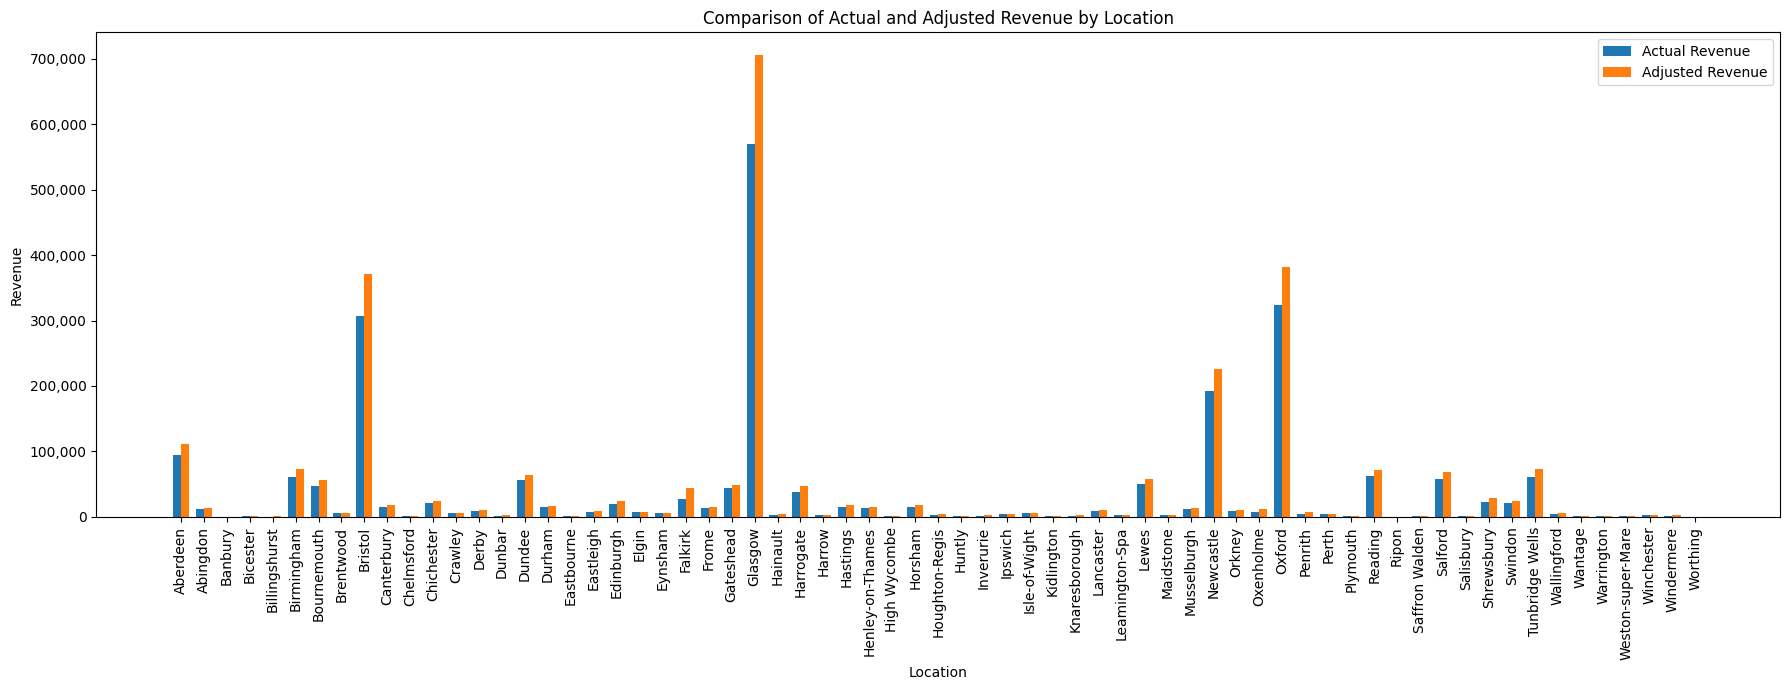

In [ ]:
plot_revenue_comparison(predictions_df)

### 4.4.2. Overall Comparison

In [ ]:
# Plot actual vs adjusted revenue
def plot_revenue_comparison_overall(df):
    # sum of actual and adjusted revenues
    actual_adjusted_revenues = predictions_df[['actual_revenue', 'adjusted_revenue']].sum()

    # Plotting the data
    plt.figure(figsize=(15, 6))

    bars = plt.bar(['Actual Revenue', 'Adjusted Revenue'], actual_adjusted_revenues, color=['blue', 'orange'])

    # Adding labels and title
    plt.xlabel('Type of Revenues')
    plt.ylabel('Revenue')
    plt.title('Comparison of Actual and Adjusted Revenues')
    plt.xticks([0, 1], ['Actual Revenue', 'Adjusted Revenue'])

    # Adding legends
    plt.legend(bars, ['Actual Revenue', 'Adjusted Revenue'])

    # Formatting the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))
    plt.xticks(rotation=0)

    # add difference of the actual and adjusted revenue on the top of the plot
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'£{yval:,.0f}', ha='center', va='bottom', fontsize=15)

    # plot difference line
    plt.plot([0, 1], [actual_adjusted_revenues['actual_revenue'], actual_adjusted_revenues['adjusted_revenue']], color='red', linestyle='--', linewidth=2, marker='o')

    # plot the difference
    actual_adjusted_revenues['difference'] = actual_adjusted_revenues['adjusted_revenue'] - actual_adjusted_revenues['actual_revenue']
    actual_adjusted_revenues['difference_pct'] = np.round(((actual_adjusted_revenues['adjusted_revenue'] - actual_adjusted_revenues['actual_revenue'])/actual_adjusted_revenues['actual_revenue'])*100, 2)
    plt.text(0.5, actual_adjusted_revenues['actual_revenue'] + (actual_adjusted_revenues['actual_revenue']*0.15), f'£{actual_adjusted_revenues["difference"]:,.0f} ({actual_adjusted_revenues["difference_pct"]} %)', ha='center', va='bottom', color='red', fontsize=17)

    # Display the plot
    plt.tight_layout()
    plt.show()

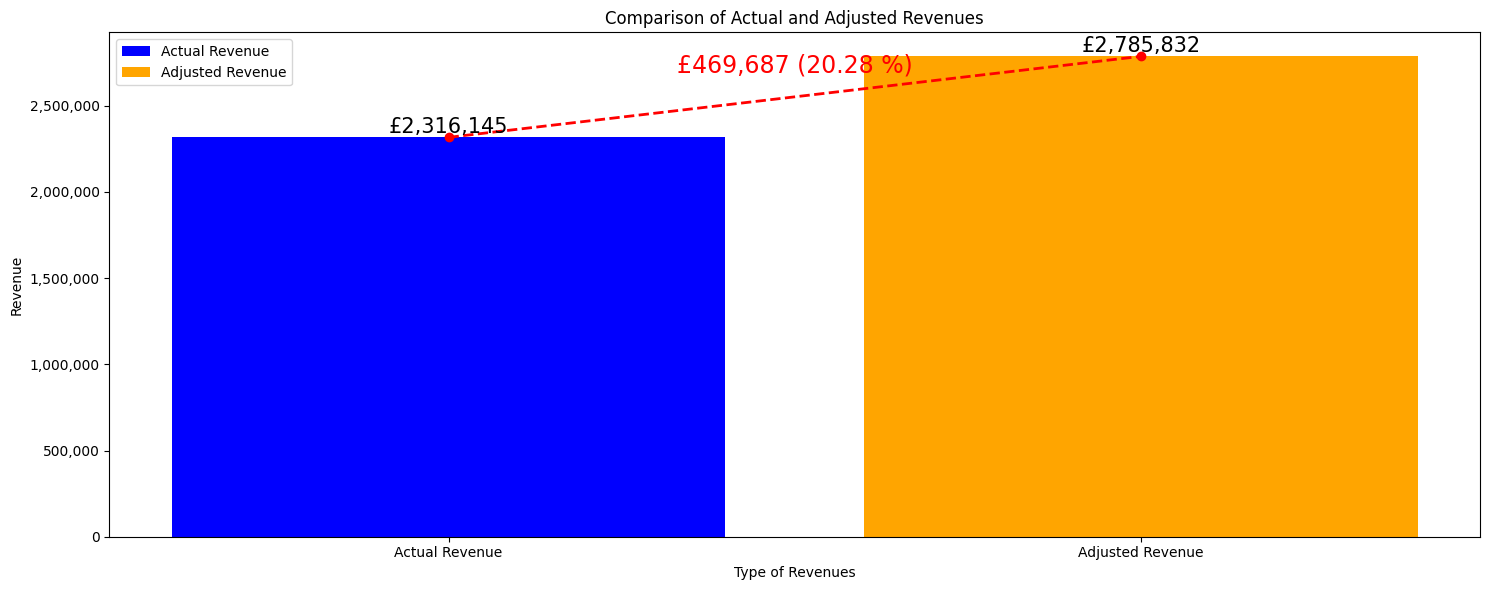

In [ ]:
plot_revenue_comparison_overall(predictions_df)

---